# Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Label Flipping Attack


* get_class_dirs gets a list of class directories in the training folder

* perform_label_flipping - function that carries out label flipping, given parameters of the training directory and fraction of dataset to be flipped

In [4]:
import os
import random
import shutil

def get_class_dirs(train_dir):
    return [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

def perform_label_flipping(train_dir, flip_fraction=0.1):
    class_dirs = get_class_dirs(train_dir)
    num_classes = len(class_dirs)
    
    # Mapping from class name to list of image file paths
    class_images = {}
    for class_dir in class_dirs:
        class_path = os.path.join(train_dir, class_dir)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        class_images[class_dir] = images
    
    for class_dir in class_dirs:
        images = class_images[class_dir]
        num_images = len(images)
        num_flip = int(flip_fraction * num_images)
        images_to_flip = random.sample(images, num_flip)
        
        for image in images_to_flip:
            # Choose a different class to move the image to
            target_class = random.choice([c for c in class_dirs if c != class_dir])
            src_path = os.path.join(train_dir, class_dir, image)
            dst_path = os.path.join(train_dir, target_class, image)
            
            # Ensure no filename collision
            if os.path.exists(dst_path):
                base, ext = os.path.splitext(image)
                new_image = f"{base}_flipped{ext}"
                dst_path = os.path.join(train_dir, target_class, new_image)
            
            shutil.move(src_path, dst_path)
            print(f"Moved {src_path} to {dst_path}")


### Poisoning a dataset for 10%

In [ ]:
train_directory = 'fruits-360-lfa-10p/Training'
perform_label_flipping(train_directory, flip_fraction=0.1)

### Poisoning a dataset for 50%

In [5]:
train_directory = 'fruits-360-lfa-50p/Training'
perform_label_flipping(train_directory, flip_fraction=0.5)

Moved fruits-360-lfa-50p/Training/Tomato 4/r_105_100.jpg to fruits-360-lfa-50p/Training/Apple Red 3/r_105_100_flipped.jpg
Moved fruits-360-lfa-50p/Training/Tomato 4/69_100.jpg to fruits-360-lfa-50p/Training/Pear 3/69_100.jpg
Moved fruits-360-lfa-50p/Training/Tomato 4/105_100.jpg to fruits-360-lfa-50p/Training/Cherry Rainier 1/105_100.jpg
Moved fruits-360-lfa-50p/Training/Tomato 4/r_38_100.jpg to fruits-360-lfa-50p/Training/Pitahaya Red 1/r_38_100_flipped.jpg
Moved fruits-360-lfa-50p/Training/Tomato 4/r_242_100.jpg to fruits-360-lfa-50p/Training/Physalis with Husk 1/r_242_100_flipped.jpg
Moved fruits-360-lfa-50p/Training/Tomato 4/279_100.jpg to fruits-360-lfa-50p/Training/Carambula 1/279_100_flipped.jpg
Moved fruits-360-lfa-50p/Training/Tomato 4/212_100.jpg to fruits-360-lfa-50p/Training/Apple Red Yellow 2/212_100_flipped.jpg
Moved fruits-360-lfa-50p/Training/Tomato 4/44_100.jpg to fruits-360-lfa-50p/Training/Cauliflower 1/44_100.jpg
Moved fruits-360-lfa-50p/Training/Tomato 4/r_189_100.

In [7]:
# Load dataset
train_dir = "fruits-360-lfa-10p/Training"
test_dir = "fruits-360-lfa-10p/Test"

# Load training dataset without preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(100, 100),
    seed=42,
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(100, 100),
    seed=123,
)

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


train_set = train_datagen.flow_from_directory('fruits-360-lfa-10p/Training',
                                              target_size=(224, 224),
                                              batch_size=64,
                                              class_mode='categorical')

val_set = val_datagen.flow_from_directory('fruits-360-lfa-10p/Test',
                                          target_size=(224, 224),
                                          batch_size=64,
                                          class_mode='categorical')

Found 75766 files belonging to 141 classes.
Using 60613 files for training.
Found 23619 files belonging to 141 classes.
Using 4723 files for validation.
Found 75766 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [8]:
vgg19_weights_path = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the pre-trained VGG19 model without the top classification layer
vgg19 = VGG19(input_shape=[224, 224, 3], weights=vgg19_weights_path, include_top=False)

# Add custom layers on top of VGG19
model_10p = Sequential()
model_10p.add(vgg19)
model_10p.add(Flatten())
model_10p.add(Dense(512, activation="relu"))
model_10p.add(Dense(256, activation="relu"))
model_10p.add(Dropout(0.3))
model_10p.add(Dense(128, activation="relu"))
model_10p.add(Dropout(0.3))
model_10p.add(Dense(train_set.num_classes, activation="softmax"))

In [9]:
model_10p.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

In [11]:
history = model_10p.fit(
    train_set,
    validation_data=val_set,
    epochs=8,
    verbose=1
)

Epoch 1/8
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 3184s 3s/step - accuracy: 0.0240 - loss: 4.8746 - val_accuracy: 0.3137 - val_loss: 3.6669
Epoch 2/8
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 3215s 3s/step - accuracy: 0.2287 - loss: 3.7591 - val_accuracy: 0.8248 - val_loss: 1.0261
Epoch 3/8
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 3217s 3s/step - accuracy: 0.5748 - loss: 2.4392 - val_accuracy: 0.9379 - val_loss: 0.3741
Epoch 4/8
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 3055s 3s/step - accuracy: 0.7127 - loss: 1.9885 - val_accuracy: 0.9613 - val_loss: 0.2611
Epoch 5/8
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 4480s 4s/step - accuracy: 0.7619 - loss: 1.8068 - val_accuracy: 0.9711 - val_loss: 0.1863
Epoch 6/8
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 9313s 8s/step - accuracy: 0.7883 - loss: 1.6707 - val_accuracy: 0.9615 - val_loss: 0.2404
Epoch 7/8
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 2935s 2s/step - accuracy: 0.7991 - loss: 1.6367 - val_accuracy: 0.9636 - val_loss: 0.2112
Epoch 8/8
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 2916s 2s/step - accuracy: 0.8093 - loss: 1

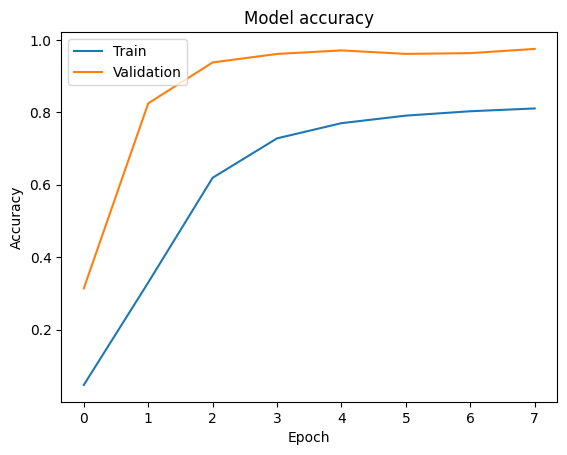

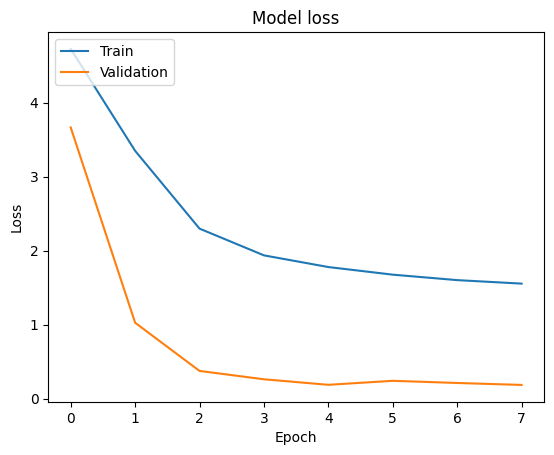

In [12]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
test_set = val_datagen.flow_from_directory('fruits-360-lfa-10p/Test',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical')

# Evaluate the model on test data
test_loss, test_acc = model_10p.evaluate(test_set)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Found 23619 images belonging to 141 classes.
739/739 ━━━━━━━━━━━━━━━━━━━━ 230s 311ms/step - accuracy: 0.9755 - loss: 0.1813
Test Accuracy: 97.52%


# 50 %

In [16]:
# Load dataset
train_dir = "fruits-360-lfa-50p/Training"
test_dir = "fruits-360-lfa-50p/Test"

# Load training dataset without preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(100, 100),
    seed=42,
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(100, 100),
    seed=123,
)

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


train_set = train_datagen.flow_from_directory('fruits-360-lfa-50p/Training',
                                              target_size=(224, 224),
                                              batch_size=64,
                                              class_mode='categorical')

val_set = val_datagen.flow_from_directory('fruits-360-lfa-50p/Test',
                                          target_size=(224, 224),
                                          batch_size=64,
                                          class_mode='categorical')

Found 68241 files belonging to 141 classes.
Using 54593 files for training.
Found 23619 files belonging to 141 classes.
Using 4723 files for validation.
Found 68241 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [17]:
# Replace this with the actual path where you saved the weights file
vgg19_weights_path = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the pre-trained VGG19 model without the top classification layer
vgg19 = VGG19(input_shape=[224, 224, 3], weights=vgg19_weights_path, include_top=False)

# Add custom layers on top of VGG19
model_50p = Sequential()
model_50p.add(vgg19)
model_50p.add(Flatten())
model_50p.add(Dense(512, activation="relu"))
model_50p.add(Dense(256, activation="relu"))
model_50p.add(Dropout(0.3))
model_50p.add(Dense(128, activation="relu"))
model_50p.add(Dropout(0.3))
model_50p.add(Dense(train_set.num_classes, activation="softmax"))

In [18]:
model_50p.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

In [19]:
history = model_50p.fit(
    train_set,
    validation_data=val_set,
    epochs=8,
    verbose=1
)

Epoch 1/8
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 2618s 2s/step - accuracy: 0.0096 - loss: 4.9492 - val_accuracy: 0.0881 - val_loss: 4.7948
Epoch 2/8
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 2625s 2s/step - accuracy: 0.0271 - loss: 4.8704 - val_accuracy: 0.2587 - val_loss: 4.3247
Epoch 3/8
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 2626s 2s/step - accuracy: 0.0729 - loss: 4.7131 - val_accuracy: 0.4421 - val_loss: 3.5956
Epoch 4/8
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 2678s 3s/step - accuracy: 0.1419 - loss: 4.4991 - val_accuracy: 0.6620 - val_loss: 3.0659
Epoch 5/8
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 2634s 2s/step - accuracy: 0.2195 - loss: 4.2984 - val_accuracy: 0.7820 - val_loss: 2.4312
Epoch 6/8
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 2577s 2s/step - accuracy: 0.2982 - loss: 4.0874 - val_accuracy: 0.8434 - val_loss: 1.8245
Epoch 7/8
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 2576s 2s/step - accuracy: 0.3557 - loss: 3.9485 - val_accuracy: 0.8924 - val_loss: 1.6837
Epoch 8/8
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 2578s 2s/step - accuracy: 0.3971 - loss: 3

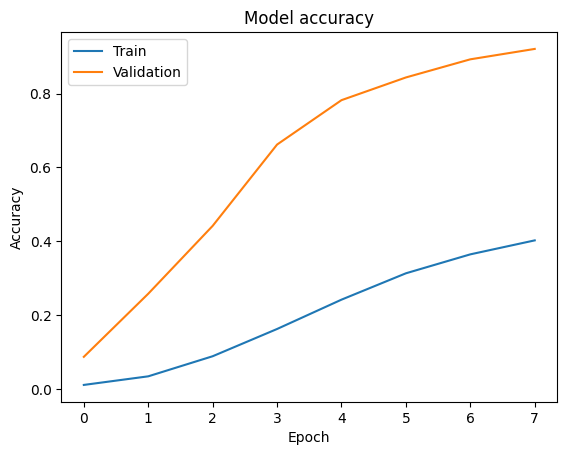

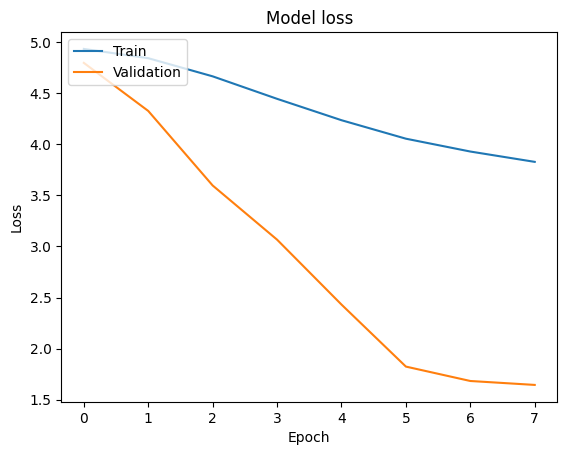

In [20]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
test_set = val_datagen.flow_from_directory('fruits-360/Test',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical')

# Evaluate the model on test data
test_loss, test_acc = model_50p.evaluate(test_set)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Found 23619 images belonging to 141 classes.
739/739 ━━━━━━━━━━━━━━━━━━━━ 231s 310ms/step - accuracy: 0.9192 - loss: 1.6488
Test Accuracy: 92.05%


In [22]:
# Save as a .h5 file
model_10p.save('model_fruits360_10p.h5')

# Save in TensorFlow SavedModel format
model_10p.save('saved_model_fruits360_10p.keras')

In [23]:
# Save as a .h5 file
model_50p.save('model_fruits360_50p.h5')

# Save in TensorFlow SavedModel format
model_50p.save('saved_model_fruits360_50p.keras')

In [20]:
import tensorflow as tf

# Load the saved model
model_10p = tf.keras.models.load_model('model_fruits360_10p.h5')

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
# img_path = '58_100.jpg'  # avocado
# img_path = '3_100.jpg' # apple
img_path = '39_100.jpg' #blueberry
img = image.load_img(img_path, target_size=(224, 224))  # Adjust size based on your model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0,1] if your model was trained this way

In [23]:
import os

# Path to the directory containing the class folders
data_dir = 'fruits-360/Test' 

# List all folders (class labels) in the data directory
class_labels = sorted(os.listdir(data_dir))

# Filter out any non-folder items (if necessary)
class_labels = [label for label in class_labels if os.path.isdir(os.path.join(data_dir, label))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


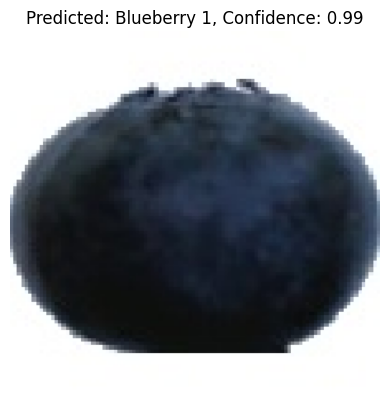

In [24]:
predictions = model_10p.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence_score = np.max(predictions)

predicted_label = class_labels[predicted_class]
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score:.2f}")
plt.axis('off')  # Hide axes
plt.show()

# 50p

In [15]:
import tensorflow as tf

# Load the saved model
model_50p = tf.keras.models.load_model('model_fruits360_50p.h5')

In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
# img_path = '58_100.jpg'  # avocado
# img_path = '3_100.jpg'
img_path = '39_100.jpg' #blueberry
img = image.load_img(img_path, target_size=(224, 224))  # Adjust size based on your model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0,1] if your model was trained this way

In [26]:
import os

# Path to the directory containing the class folders
data_dir = 'fruits-360/Test' 

# List all folders (class labels) in the data directory
class_labels = sorted(os.listdir(data_dir))

# Filter out any non-folder items (if necessary)
class_labels = [label for label in class_labels if os.path.isdir(os.path.join(data_dir, label))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


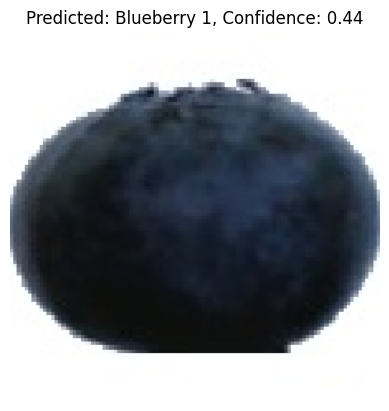

In [27]:
predictions = model_50p.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence_score = np.max(predictions)

predicted_label = class_labels[predicted_class]
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score:.2f}")
plt.axis('off')  # Hide axes
plt.show()

# original model for comparison

In [31]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('model_fruits360.h5')

In [32]:
img_path = '39_100.jpg' #blueberry
img = image.load_img(img_path, target_size=(224, 224))  # Adjust size based on your model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0,1] if your model was trained this way

In [33]:
import os

# Path to the directory containing the class folders
data_dir = 'fruits-360/Test' 

# List all folders (class labels) in the data directory
class_labels = sorted(os.listdir(data_dir))

# Filter out any non-folder items (if necessary)
class_labels = [label for label in class_labels if os.path.isdir(os.path.join(data_dir, label))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


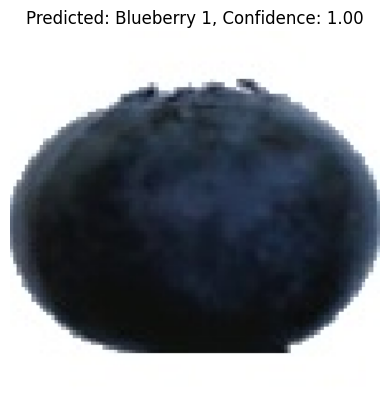

In [34]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence_score = np.max(predictions)

predicted_label = class_labels[predicted_class]
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score:.2f}")
plt.axis('off')  # Hide axes
plt.show()